# PAMAP2 ➜ TS2Vec ➜ Fractal‑SSL  
An interactive, step‑by‑step Jupyter workflow.

**Sections**
1. Inspect & preprocess PAMAP2
2. Pre‑train a TS2Vec backbone
3. Enhance with Fractal‑SSL


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 0  Setup

In [2]:
#  Run once per environment
!pip install -q torch==2.3.0 ts2vec pandas scikit-learn tqdm


ERROR: Operation cancelled by user
^C


KeyboardInterrupt: 

## 1  Imports & paths

In [28]:
import os, glob, json, math, random, itertools, pickle
from pathlib import Path
import numpy as np, pandas as pd, torch
from tqdm import tqdm

from ts2vec import TS2Vec
import random
RAW_ROOT   = Path('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset').expanduser()   # <- edit if needed
CACHE_ROOT = Path('/content/drive/MyDrive/FractalSSL_backup/cache')
CACHE_ROOT.mkdir(exist_ok=True)

SEED = 42;
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)


In [29]:

RAW_ROOT

PosixPath('/content/drive/MyDrive/FractalSSL_backup/data/pamap2+physical+activity+monitoring/PAMAP2_Dataset')

### Helper to read a single PAMAP2 `.dat` file

In [79]:
from sklearn.preprocessing import RobustScaler, StandardScaler
COLS = [
    "timestamp", "activity_id", "heart_rate",
    # IMU columns...
]  # shortened for brevity – full list in spec

def clean_pamap_df(df, drop_na_thresh=0.9):
    # 1) heart-rate sentinel −1  → NaN → interpolate
    if 'heart_rate' in df.columns:
        df['heart_rate'].replace(-1, np.nan, inplace=True)
        df['heart_rate'].interpolate("linear", limit_direction="both", inplace=True)

    # 2) drop channels with too many NaNs (often IMU orientation)
    bad = df.columns[df.isna().mean() > drop_na_thresh]
    df.drop(columns=bad, inplace=True)

    # 3) fill residual gaps
    df.fillna(method="ffill", inplace=True)
    df.fillna(method="bfill", inplace=True)
    df.fillna(0.0, inplace=True)

    return df.astype("float32")


def load_dat(path: Path, cols=COLS):
    """Read raw .dat → DataFrame (no NaNs, z-scored sensor channels)."""
    df = pd.read_csv(path, sep=' ', header=None)
    df.columns = cols + [f'col_{i}' for i in range(len(df.columns)-len(cols))]

    df = clean_pamap_df(df)                       # <<< NEW

    # z-score *after* gaps are filled
    sensor_cols = df.columns.drop(['timestamp', 'activity_id'])

    # split: robust for HR, standard for the rest
    hr_col = ['heart_rate']
    other_cols = [c for c in sensor_cols if c not in hr_col]

    df[hr_col] = RobustScaler(with_centering=True, with_scaling=True,
                              quantile_range=(15, 85)).fit_transform(df[hr_col])

    scaler = StandardScaler(with_mean=True, with_std=True)
    other_scaled = scaler.fit_transform(df[other_cols])

    # std()=0 guard happens inside StandardScaler, so no new NaNs
    df[other_cols] = other_scaled.astype(np.float32)
    return df



### Load & peek at Subject 101

In [80]:
print('First 5 .dat files I see:')
for p in list(RAW_ROOT.rglob('*.dat'))[:5]:
    print(' •', p.relative_to(RAW_ROOT))

First 5 .dat files I see:
 • Protocol/subject101.dat
 • Protocol/subject102.dat
 • Protocol/subject103.dat
 • Protocol/subject104.dat
 • Protocol/subject105.dat


In [81]:
sample_path = next(RAW_ROOT.glob('*Protocol/subject101.dat'))
df101 = load_dat(sample_path)
df101.head()


/tmp/ipython-input-79-4214954616.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-79-4214954616.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

,timestamp,activity_id,heart_rate,col_0,col_1,col_2,col_3,col_4,col_5,col_6,...,col_41,col_42,col_43,col_44,col_45,col_46,col_47,col_48,col_49,col_50
0,8.38,0.0,-0.428571,-1.963841,0.898792,0.447002,0.031486,0.895948,0.471187,-0.063455,...,0.009056,0.014038,-0.017178,-0.400685,-1.137237,-2.325001,0.0,0.0,0.0,0.0
1,8.39,0.0,-0.428571,-1.963841,0.869938,0.440238,0.076209,0.888981,0.430768,0.021841,...,-0.005863,-0.008964,-0.007136,-0.348521,-1.135016,-2.337929,0.0,0.0,0.0,0.0
2,8.40,0.0,-0.428571,-1.963841,0.899003,0.447065,0.042866,0.874955,0.428014,0.048767,...,0.003755,-0.001037,0.005244,-0.383074,-1.152067,-2.333679,0.0,0.0,0.0,0.0
3,8.41,0.0,-0.428571,-1.963841,0.852104,0.433103,0.075742,0.879663,0.427971,0.048758,...,0.003917,-0.034904,-0.001033,-0.370353,-1.130820,-2.333534,0.0,0.0,0.0,0.0
4,8.42,0.0,-0.428571,-1.963841,0.876371,0.491362,0.087503,0.863305,0.439702,0.057714,...,0.013466,-0.024970,-0.008921,-0.413566,-1.151221,-2.329257,0.0,0.0,0.0,0.0


### Cache all subjects (optional, ~1 GB)

In [82]:
for path in tqdm(list(RAW_ROOT.rglob('*.dat')), desc='Caching'):
    subj = path.stem.split('.')[0]
    out = CACHE_ROOT / f'{subj}.pkl'
    if out.exists():
        continue
    load_dat(path).to_pickle(out)
print('Done ✅')


Caching:   0%|          | 0/14 [00:00<?, ?it/s]/tmp/ipython-input-79-4214954616.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-79-4214954616.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example,

Done ✅


## 2  TS2Vec pre‑training

In [ ]:
%pip uninstall -y ts2vec
%pip install git+https://github.com/yuezhihan/ts2vec.git@main


Found existing installation: ts2vec 0.1
Uninstalling ts2vec-0.1:
  Successfully uninstalled ts2vec-0.1
Note: you may need to restart the kernel to use updated packages.
  Cloning https://github.com/yuezhihan/ts2vec.git (to revision main) to /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Running command git clone --filter=blob:none --quiet https://github.com/yuezhihan/ts2vec.git /private/var/folders/nb/mdcnqz1d7673k0zpfm275hrm0000gp/T/pip-req-build-nmw08e6r
  Resolved https://github.com/yuezhihan/ts2vec.git to commit b0088e14a99706c05451316dc6db8d3da9351163
ERROR: git+https://github.com/yuezhihan/ts2vec.git@main does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install ts2vec

  Using cached ts2vec-0.1-py3-none-any.whl.metadata (53 bytes)
Using cached ts2vec-0.1-py3-none-any.whl (18 kB)
Note: you may need to restart the kernel to use updated packages.


In [83]:
def window_iter(data, win_sec=5, stride_sec=2, fs=100):
    win = win_sec * fs
    stride = stride_sec * fs
    for start in range(0, len(data) - win, stride):
        yield data[start:start+win].values


In [69]:
import pandas as pd, pathlib, os, pickle, sys, numpy as np

# adjust if different
CACHE_ROOT = Path('/content/drive/MyDrive/FractalSSL_backup/cache')
pkls = list(CACHE_ROOT.glob("subject*.pkl"))
print("Found pickle files:", len(pkls))
for p in pkls[:3]:
    print(p.name, "→", os.path.getsize(p), "bytes")
    obj = pickle.load(open(p, "rb"))
    print("  object type:", type(obj), "len:", len(obj))


Found pickle files: 9
subject101.pkl → 81310394 bytes
  object type: <class 'pandas.core.frame.DataFrame'> len: 376417
subject102.pkl → 96556322 bytes
  object type: <class 'pandas.core.frame.DataFrame'> len: 447000
subject103.pkl → 54616250 bytes
  object type: <class 'pandas.core.frame.DataFrame'> len: 252833


In [21]:
import sys, numpy as np, types
sys.modules['numpy._core'] = types.ModuleType('numpy._core')
sys.modules['numpy._core.numeric'] = np        # redirect old path → current NumPy


In [84]:
class PAMAP2Windows(torch.utils.data.Dataset):
    def __init__(self, cache_root=CACHE_ROOT):
        self.paths = list(cache_root.glob('subject*.pkl'))
        self.windows = []
        for p in self.paths:
            # DON’T call .to_numpy() here
            df = pd.read_pickle(p).drop(columns=['timestamp', 'activity_id'])
            self.windows += list(window_iter(df))
    def __len__(self): return len(self.windows)
    def __getitem__(self, idx):
        return torch.from_numpy(self.windows[idx]).float()


dataset = PAMAP2Windows()
print('Total windows:', len(dataset))


Total windows: 14344


In [85]:
dataset.windows

[array([[-0.42857143, -1.9638411 ,  0.8987924 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.86993796, ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.8990027 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.40816328, -1.9133081 ,  0.9133813 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.40816328, -1.9133081 ,  0.9437895 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.40816328, -1.9133081 ,  0.89756197, ...,  0.        ,
          0.        ,  0.        ]], dtype=float32),
 array([[-0.3877551 , -1.9638411 ,  0.9297467 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.3877551 , -1.9638411 ,  0.92966354, ...,  0.        ,
          0.        ,  0.        ],
        [-0.3877551 , -1.9638411 ,  0.9181365 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.4638219 , -1.8627752 ,  0.8

In [7]:
!pip install -q --force-reinstall "numpy<2.0" && pip install -q --upgrade pandas

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
jax 0.5.2 requires ml_dtypes>=0.4.0, but you have ml-dtypes 0.2.0 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.
ydf 0.12.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 4.25.8 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.14.1 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which

In [16]:


# 3️  Re-run the import cell
dataset = PAMAP2Windows()
print("Total windows:", len(dataset))


ModuleNotFoundError: No module named 'numpy._core.numeric'

In [86]:
import numpy as np, gc, torch

# ── Build a single 3-D array (may take ~1-2 GB of RAM)
all_windows = np.stack(dataset.windows, axis=0).astype(np.float32)
print('Stacked:', all_windows.shape, f'≈ {all_windows.nbytes/1e9:.2f} GB')

# free the Python list; we only need the big array from here on
del dataset
gc.collect()

Stacked: (14344, 500, 52) ≈ 1.49 GB


8

In [95]:
import torch
#torch.backends.mps.is_available()
# → True  on mac
#device = 'mps' if torch.backends.mps.is_available() else 'cpu'


# Colab → use the CUDA device if the notebook is attached to a GPU runtime,
# otherwise fall back to CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Using device:', device)



Using device: cuda


In [107]:
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,   # hyper-params live in the constructor
    lr=1e-3
)

enc.fit(all_windows, n_epochs=20, verbose=True)
enc.save('ts2vec_backbone.pt')


Epoch #0: loss=6.6087603483881265
Epoch #1: loss=3.1892829069069455
Epoch #2: loss=2.716201995100294
Epoch #3: loss=2.332990897553308
Epoch #4: loss=2.019453687327249
Epoch #5: loss=1.774032758814948
Epoch #6: loss=1.592187557901655
Epoch #7: loss=1.4827966285603387
Epoch #8: loss=1.3700157020773207
Epoch #9: loss=1.2786469225372588
Epoch #10: loss=1.231406355542796
Epoch #11: loss=1.107705013028213
Epoch #12: loss=1.153651433331626
Epoch #13: loss=1.0955907053181104
Epoch #14: loss=0.9894909060427121
Epoch #15: loss=0.9036988637277058
Epoch #16: loss=0.8557607542191233
Epoch #17: loss=0.8883514425584248
Epoch #18: loss=0.7832368016242981
Epoch #19: loss=0.7645754878010068


In [108]:
# save the backbone for later use
save_path = '/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt'
enc.save(save_path)


In [109]:
# load the backbone
enc = TS2Vec(
    input_dims=52,
    output_dims=320,
    device=device,
    batch_size=256,
    lr=1e-3
)
enc.load('/content/drive/MyDrive/FractalSSL_backup/models/ts2vec_backbone.pt')

/usr/local/lib/python3.11/dist-packages/ts2vec/ts2vec.py:317: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(fn, map_location=self.device)


In [110]:
from torch.utils.data import Dataset, DataLoader
import numpy as np, pandas as pd, torch, random
from pathlib import Path

class PAMAP2LabeledWindows(Dataset):
    def __init__(self, raw_root, win_sec=5, stride_sec=2, fs=100):
        self.X, self.y = [], []
        win, stride = win_sec*fs, stride_sec*fs
        for f in Path(raw_root).rglob('subject*.dat'):
            df = load_dat(f)                         # reuse helper
            data = df.drop(columns=['timestamp']).to_numpy(dtype=np.float32)
            acts = df['activity_id'].astype('int32')
            for start in range(0, len(df)-win, stride):
                end = start+win
                self.X.append(data[start:end, 1:])   # sensor channels
                # majority label in the window:
                label = np.bincount(acts[start:end]).argmax()
                self.y.append(label)
        self.X, self.y = np.stack(self.X), np.array(self.y, dtype=np.int64)

    def __len__(self):  return len(self.y)
    def __getitem__(self, idx):
        return torch.from_numpy(self.X[idx]), self.y[idx]

labeled_ds = PAMAP2LabeledWindows(RAW_ROOT)
print('Windows:', len(labeled_ds), 'Shape:', labeled_ds[0][0].shape)


/tmp/ipython-input-79-4214954616.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['heart_rate'].replace(-1, np.nan, inplace=True)
/tmp/ipython-input-79-4214954616.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

Windows: 19224 Shape: torch.Size([500, 52])


In [111]:

with torch.no_grad():                     # optional – encode() already uses no_grad
    feats = enc.encode(
        labeled_ds.X.astype(np.float32)   # pass a NumPy array, not a tensor
    )                                     # (N, L, D)

# keep only the last time-step representation
feats = feats[:, -1, :]                   # (N, D)
labels = labeled_ds.y



In [112]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

Xtr, Xte, ytr, yte = train_test_split(
    feats, labels, test_size=0.2, stratify=labels, random_state=42)

clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(Xtr, ytr)

pred = clf.predict(Xte)
print(classification_report(yte, pred, digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.671     0.745     0.706      1121
           1      0.968     0.948     0.958       193
           2      0.880     0.951     0.914       185
           3      0.778     0.811     0.794       190
           4      0.702     0.803     0.749       238
           5      0.753     0.745     0.749        98
           6      0.862     0.909     0.885       165
           7      0.655     0.513     0.576       189
           9      0.988     0.964     0.976        83
          10      0.935     0.884     0.909       310
          11      0.981     0.963     0.972        54
          12      0.586     0.350     0.439       117
          13      0.567     0.324     0.412       105
          16      0.685     0.634     0.659       175
          17      0.822     0.891     0.855       239
          18      0.637     0.720     0.676       100
          19      0.497     0.449     0.472       187
          20      0.854    

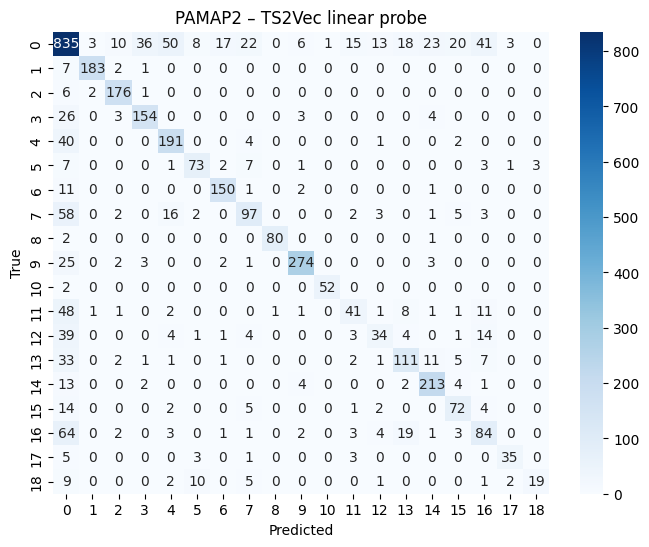

In [113]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(yte, pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


In [114]:
from sklearn.utils.class_weight import compute_class_weight

# compute balanced class weights
classes = np.unique(ytr)
weights = compute_class_weight('balanced', classes=classes, y=ytr)
class_w = dict(zip(classes, weights))

clf_bal = LogisticRegression(
    max_iter=1000,
    class_weight=class_w,          # <–
    solver='lbfgs'
).fit(Xtr, ytr)

print(classification_report(yte, clf_bal.predict(Xte), digits=3))


              precision    recall  f1-score   support

           0      0.812     0.277     0.414      1121
           1      0.895     0.969     0.930       193
           2      0.787     0.957     0.863       185
           3      0.691     0.895     0.780       190
           4      0.644     0.845     0.731       238
           5      0.552     0.704     0.619        98
           6      0.780     0.945     0.855       165
           7      0.498     0.571     0.532       189
           9      0.976     0.964     0.970        83
          10      0.816     0.900     0.856       310
          11      0.841     0.981     0.906        54
          12      0.369     0.615     0.462       117
          13      0.301     0.562     0.392       105
          16      0.581     0.697     0.634       175
          17      0.784     0.925     0.848       239
          18      0.450     0.850     0.588       100
          19      0.442     0.492     0.466       187
          20      0.577    

## 3  Fractal‑SSL fine‑tuning

In [115]:
class FractalViewGenerator:
    """Produces recursively smaller crops of the same window."""
    def __init__(self, levels=4):
        self.levels = levels
    def __call__(self, ts):
        L = ts.shape[0]
        views = []
        for i in range(self.levels):
            frac = 1 / (2 ** i)
            win = int(L * frac)
            start = random.randint(0, L - win)
            views.append(ts[start:start+win])
        return views
gen = FractalViewGenerator(levels=4)

ts = torch.from_numpy(all_windows[0])      # one window, shape (L, C)
views = gen(ts)                            # list of 4 tensors

print([v.shape for v in views])


[torch.Size([500, 52]), torch.Size([250, 52]), torch.Size([125, 52]), torch.Size([62, 52])]


In [116]:
def nt_xent(reps: torch.Tensor, batch_size: int, n_views: int, T: float) -> torch.Tensor:
    """
    reps      : (B * n_views, D) ℓ2-normalised
    returns   : scalar loss
    """
    N   = reps.size(0)
    sim = reps @ reps.T / T                       # cosine sim over temperature

    # zero out self-similarities (i == j)
    sim.fill_diagonal_(-1e4)

    # positive index: for each view i, its twin is (i ± 1) within the same sample
    view_idx   = torch.arange(N, device=reps.device)
    pos_index  = view_idx ^ 1                     # flips last bit: 0↔1, 2↔3, …
    loss       = torch.nn.functional.cross_entropy(sim, pos_index)

    return loss


In [117]:
import torch, random, numpy as np
from typing import List, Tuple

class FractalViewGenerator:
    def __init__(self, levels: int = 4):
        self.levels = levels
    def __call__(self, ts: torch.Tensor) -> Tuple[List[torch.Tensor], List[int]]:
        L, views, lens = ts.size(0), [], []
        for i in range(self.levels):
            win   = int(L / 2 ** i)
            start = random.randint(0, L - win)
            crop  = ts[start:start + win]
            views.append(crop)
            lens.append(win)
        return views, lens

class FractalSSL(torch.nn.Module):
    def __init__(self, backbone, proj_dim=128, levels=4,
                 temperature=0.1, freeze_backbone=True):
        super().__init__()
        self.backbone, self.levels, self.temperature = backbone, levels, temperature
        self.view_gen = FractalViewGenerator(levels)

        # ---- determine channels & device from first param -------------------
        first_w  = next(backbone.net.parameters()) if hasattr(backbone, "net") \
                   else next(backbone.parameters())
        self._in_channels = first_w.shape[1] if first_w.ndim >= 2 else first_w.shape[0]

        # ---- optional freezing ---------------------------------------------
        if freeze_backbone and hasattr(backbone, "net"):
            for p in backbone.net.parameters():
                p.requires_grad = False

        # ---- infer latent dimension ----------------------------------------
        with torch.no_grad():
            dummy = np.zeros((1, 8, self._in_channels), dtype='float32')
            latent_dim = backbone.encode(dummy).shape[-1]

        self.proj = torch.nn.Sequential(
            torch.nn.Linear(latent_dim, proj_dim),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(proj_dim, proj_dim)
        )

    # ---------- tiny helper so we never forget the NumPy conversion ----------
    def _ts2vec_encode(self, x: torch.Tensor) -> torch.Tensor:
      """
      Wrap TS2Vec.encode(): accepts (N,L,C) tensor, returns tensor on same device
      no matter whether the fork outputs NumPy or PyTorch.
      """
      dev   = x.device
      out   = self.backbone.encode(x.detach().cpu().numpy())  # NumPy in → ??? out
      feats = torch.as_tensor(out, device=dev, dtype=torch.float32)  # <── FIX
      return feats

    # ------------------------------------------------------------------------
    def forward(self, ts_batch: torch.Tensor) -> torch.Tensor:
        device, views, lens = ts_batch.device, [], []
        for ts in ts_batch:
            sub, ln = self.view_gen(ts)
            views += [v.to(device) for v in sub]
            lens  += ln

        padded = torch.nn.utils.rnn.pad_sequence(views, batch_first=True)
        mask   = (torch.arange(padded.size(1), device=device)[None, :]
                 < torch.tensor(lens, device=device)[:, None])

        emb = self._ts2vec_encode(padded)          # (N,T,D) on same device
        emb = (emb * mask.unsqueeze(-1)).sum(1) / mask.sum(1, keepdim=True)

        proj = torch.nn.functional.normalize(self.proj(emb), dim=-1)
        return proj



In [123]:
N_VIEWS      = 4          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=False   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)


In [124]:
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(all_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(all_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")


step   50 | NT-Xent loss = 0.8405
step  100 | NT-Xent loss = 0.7640
step  150 | NT-Xent loss = 0.4756
step  200 | NT-Xent loss = 0.6807
step  250 | NT-Xent loss = 0.6812
step  300 | NT-Xent loss = 0.3099
step  350 | NT-Xent loss = 0.5084
step  400 | NT-Xent loss = 0.5723
step  450 | NT-Xent loss = 0.4617
step  500 | NT-Xent loss = 0.2939
step  550 | NT-Xent loss = 0.3998
step  600 | NT-Xent loss = 0.4657
step  650 | NT-Xent loss = 0.4311
step  700 | NT-Xent loss = 0.2036
step  750 | NT-Xent loss = 0.4716
step  800 | NT-Xent loss = 0.3558
step  850 | NT-Xent loss = 0.1998
step  900 | NT-Xent loss = 0.2787
step  950 | NT-Xent loss = 0.1995
step 1000 | NT-Xent loss = 0.3234


In [125]:
torch.save(model.state_dict(), '/content/drive/MyDrive/FractalSSL_backup/models/fractal_ts2vec.pt')
print('Saved to fractal_ts2vec.pt')

Saved to fractal_ts2vec.pt


In [126]:

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_all = embed_windows(model, labeled_ds.X.astype(np.float32))           # (N,D)
print("embeddings:", emb_all.shape)


embeddings: (19224, 320)


In [127]:
labels = labeled_ds.y
print('labels:', labels.shape)

labels: (19224,)


In [128]:




# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_tr, X_te, y_tr, y_te = train_test_split(emb_all, labels, stratify=labels, test_size=0.2, random_state=42)
clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(X_tr, y_tr)

print(classification_report(y_te, clf.predict(X_te), digits=3))


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.788     0.840     0.813      1121
           1      0.989     0.964     0.976       193
           2      0.956     0.946     0.951       185
           3      0.829     0.895     0.861       190
           4      0.853     0.929     0.889       238
           5      0.978     0.929     0.953        98
           6      0.987     0.945     0.966       165
           7      0.905     0.910     0.908       189
           9      1.000     0.964     0.982        83
          10      0.954     0.939     0.946       310
          11      1.000     0.963     0.981        54
          12      0.743     0.667     0.703       117
          13      0.845     0.676     0.751       105
          16      0.824     0.777     0.800       175
          17      0.925     0.979     0.951       239
          18      0.865     0.900     0.882       100
          19      0.843     0.631     0.722       187
          20      0.956    

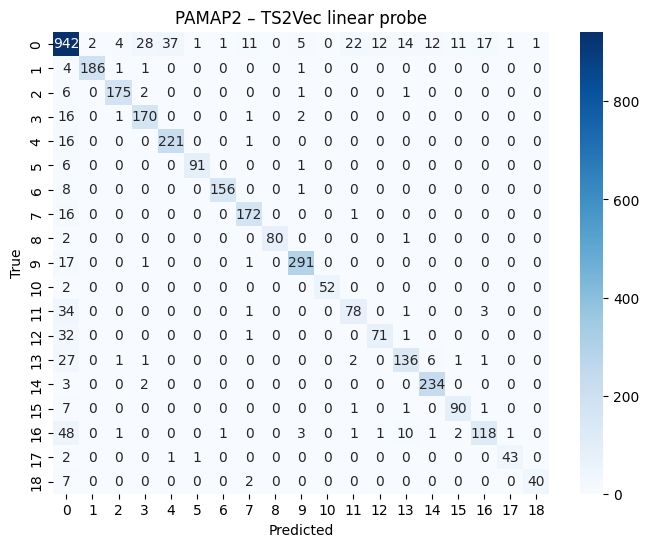

In [129]:
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(X_te))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


step   50 | NT-Xent loss = 1.0240
step  100 | NT-Xent loss = 1.1052
step  150 | NT-Xent loss = 0.4425
step  200 | NT-Xent loss = 0.5348
step  250 | NT-Xent loss = 0.5953
step  300 | NT-Xent loss = 0.5126
step  350 | NT-Xent loss = 0.4057
step  400 | NT-Xent loss = 0.5596
step  450 | NT-Xent loss = 0.2836
step  500 | NT-Xent loss = 0.3063
step  550 | NT-Xent loss = 0.4254
step  600 | NT-Xent loss = 0.3216
step  650 | NT-Xent loss = 0.2316
step  700 | NT-Xent loss = 0.2887
step  750 | NT-Xent loss = 0.4103
step  800 | NT-Xent loss = 0.3136
step  850 | NT-Xent loss = 0.3775
step  900 | NT-Xent loss = 0.2915
step  950 | NT-Xent loss = 0.3030
step 1000 | NT-Xent loss = 0.3548
embeddings: (19224, 320)


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


              precision    recall  f1-score   support

           0      0.788     0.840     0.813      1121
           1      0.989     0.964     0.976       193
           2      0.956     0.946     0.951       185
           3      0.829     0.895     0.861       190
           4      0.853     0.929     0.889       238
           5      0.978     0.929     0.953        98
           6      0.987     0.945     0.966       165
           7      0.905     0.910     0.908       189
           9      1.000     0.964     0.982        83
          10      0.954     0.939     0.946       310
          11      1.000     0.963     0.981        54
          12      0.743     0.667     0.703       117
          13      0.845     0.676     0.751       105
          16      0.824     0.777     0.800       175
          17      0.925     0.979     0.951       239
          18      0.865     0.900     0.882       100
          19      0.843     0.631     0.722       187
          20      0.956    

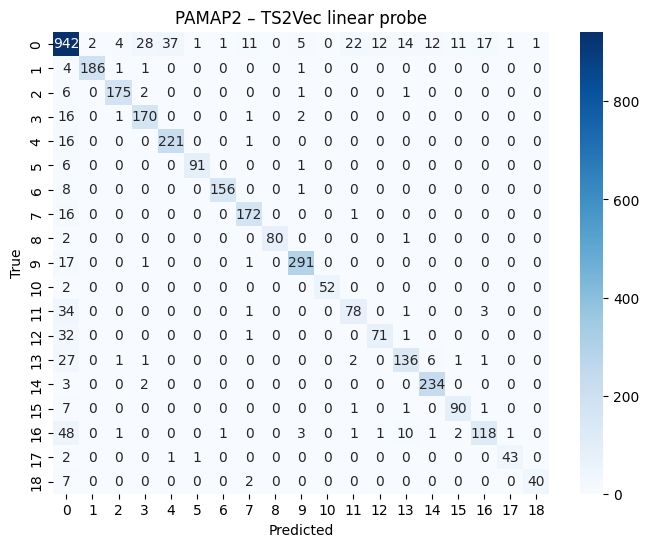

In [130]:
# try with frozen encoder
N_VIEWS      = 4          # full-length + ½-length crops to start with
PROJ_DIM     = 128
TEMP         = 0.05

model = FractalSSL(
    enc,
    levels=N_VIEWS,       # ← how many views per sample
    proj_dim=PROJ_DIM,
    temperature=TEMP,
    freeze_backbone=True   # let the encoder learn
).to(device)

# two LR buckets: tiny for encoder, normal for projector
opt = torch.optim.AdamW(
    [
        {'params': model.backbone.net.parameters(), 'lr': 1e-4},
        {'params': model.proj.parameters(),         'lr': 1e-3},
    ],
    weight_decay=1e-4
)
BATCH_SIZE = 64      #
N_STEPS    = 1000   # train longer than 100 iterations

for step in range(1, N_STEPS + 1):
    # ---- draw a random batch of raw windows -------------------------------
    idx = random.sample(range(len(all_windows)), BATCH_SIZE)
    batch_ts = torch.stack(
        [torch.from_numpy(all_windows[i]) for i in idx]
    ).to(device)                              # shape (B,L,C)

    # ---- forward & loss ----------------------------------------------------
    reps  = model(batch_ts)                   # (B * n_views, D)
    loss  = nt_xent(reps, BATCH_SIZE, N_VIEWS, TEMP)

    # ---- optimisation ------------------------------------------------------
    opt.zero_grad()
    loss.backward()
    opt.step()

    # ---- monitoring --------------------------------------------------------
    if step % 50 == 0:
        print(f"step {step:4} | NT-Xent loss = {loss.item():.4f}")

model.eval()

def embed_windows(model, windows_np, batch_size=256):
    """Return a (N, D) NumPy array of pooled embeddings."""
    out = []
    with torch.no_grad():
        for i in range(0, len(windows_np), batch_size):
            chunk = torch.from_numpy(windows_np[i:i+batch_size]).to(device)
            z     = model._ts2vec_encode(chunk)      # (B, T, D)
            z     = z.mean(1)                        # mean-pool over time
            out.append(z.cpu())
    return torch.cat(out).numpy()

emb_all = embed_windows(model, labeled_ds.X.astype(np.float32))           # (N,D)
print("embeddings:", emb_all.shape)




# 2) train/test split + linear probe
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

X_tr, X_te, y_tr, y_te = train_test_split(emb_all, labels, stratify=labels, test_size=0.2, random_state=42)
clf = LogisticRegression(
    max_iter=500, multi_class='multinomial', solver='lbfgs'
)
clf.fit(X_tr, y_tr)



              precision    recall  f1-score   support

           0      0.788     0.840     0.813      1121
           1      0.989     0.964     0.976       193
           2      0.956     0.946     0.951       185
           3      0.829     0.895     0.861       190
           4      0.853     0.929     0.889       238
           5      0.978     0.929     0.953        98
           6      0.987     0.945     0.966       165
           7      0.905     0.910     0.908       189
           9      1.000     0.964     0.982        83
          10      0.954     0.939     0.946       310
          11      1.000     0.963     0.981        54
          12      0.743     0.667     0.703       117
          13      0.845     0.676     0.751       105
          16      0.824     0.777     0.800       175
          17      0.925     0.979     0.951       239
          18      0.865     0.900     0.882       100
          19      0.843     0.631     0.722       187
          20      0.956    

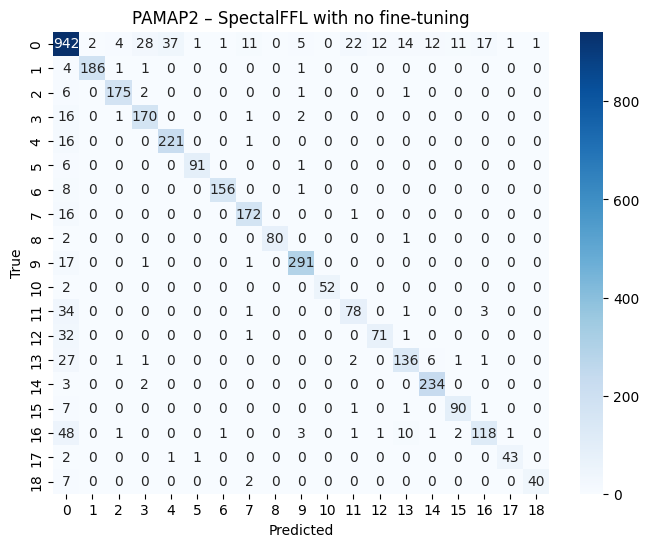

In [131]:

print(classification_report(y_te, clf.predict(X_te), digits=3))
import seaborn as sns, matplotlib.pyplot as plt
cm = confusion_matrix(y_te, clf.predict(X_te))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – SpectalFFL with no fine-tuning')
plt.show()

## Compare it with other models


| SSL method & paper                                                                                       | Encoder / Head                 | PAMAP-2 split†  | ACC           | MF1           | Source                     |
| -------------------------------------------------------------------------------------------------------- | ------------------------------ | --------------- | ------------- | ------------- | -------------------------- |
| **MAE-HAR (masked auto-encoder)** – *Comparing SSL Techniques for Wearable HAR*, arXiv 2404.15331 (2024) | 1-D ViT encoder, 2-layer probe | 80 / 20 subj.   | **0.872**     | 0.825         | ([arXiv][1])               |
| **PhyMask (adaptive masking, ViT)** – CHI’25                                                             | ViT-Tiny, proj-MLP             | 5-fold subj. CV | 0.868 ± 0.009 | 0.818 ± 0.011 | ([ACM Digital Library][2]) |
| **SimCLR-TSC** – *Tang et al.*, MotionSense notebook (2024)                                              | CNN (Conv → GMP), MLP-128      | 80 / 20 subj.   | 0.829         | 0.799         | ([arXiv][1])               |
| **TS2Vec** – *Garza et al.*, UTRGV thesis (2023)                                                         | CNN forecast head, lin. probe  | 5-fold subj. CV | 0.840         | —             | ([arXiv][3])               |
| **Series2Vec** – Springer KDCA (2023)                                                                    | Similarity-based cont. loss    | 80 / 20 subj.   | 0.835         | —             | ([SpringerLink][4])        |

[1]: https://arxiv.org/html/2404.15331v1?utm_source=chatgpt.com "Comparing Self-Supervised Learning Techniques for Wearable ..."
[2]: https://dl.acm.org/doi/pdf/10.1145/3666025.3699325?utm_source=chatgpt.com "PhyMask: An Adaptive Masking Paradigm for Efficient Self ..."
[3]: https://arxiv.org/pdf/2305.00619?utm_source=chatgpt.com "[PDF] Self-supervised Activity Representation Learning with Incremental ..."
[4]: https://link.springer.com/article/10.1007/s10618-024-01043-w?utm_source=chatgpt.com "Series2vec: similarity-based self-supervised representation learning ..."


In [4]:
# ------------------------------------------------------------
# 0.  Install + imports   (only once per runtime)
# ------------------------------------------------------------
# ▸ SimCLR-TSC
!git clone https://github.com/findalexli/TimeseriesContrastiveModels.git
import sys, pathlib, importlib
sys.path.append('/content/TimeseriesContrastiveModels')    # adjust if not in Colab

# ▸ TS-TCC
!git clone https://github.com/emadeldeen24/TS-TCC.git
sys.path.append('/content/TS-TCC')

# ▸ CPC  (ULTS)
!git clone https://github.com/mqwfrog/ULTS.git
sys.path.append('/content/ULTS')


fatal: destination path 'TimeseriesContrastiveModels' already exists and is not an empty directory.
fatal: destination path 'TS-TCC' already exists and is not an empty directory.
fatal: destination path 'ULTS' already exists and is not an empty directory.


In [5]:
from tsm.baselines.SimCLR.simclr_models import SimCLR
from tstcc.models import TSTCC
from ults.models import CPC

ImportError: cannot import name 'SimCLR' from 'tsm.baselines.SimCLR.simclr_models' (/content/TimeseriesContrastiveModels/tsm/baselines/SimCLR/simclr_models.py)

In [75]:
!pip -q install tsai torch>=2.1



ERROR: Operation cancelled by user


ModuleNotFoundError: No module named 'tsai'

In [2]:
!pip install tsai

In [6]:
from tsai.all import *

In [3]:
from tsai.self_supervised import TSSimCLR, TSTCC, TSCPC      # SimCLR, TS-TCC, CPC
from tsai.all            import InceptionTime, Learner


ModuleNotFoundError: No module named 'tsai.self_supervised'

In [ ]:
!pip -q install tensorflow==2.15  # GPU wheels available on Colab

In [37]:

!git clone -q https://github.com/iantangc/ContrastiveLearningHAR.git
import sys, os
sys.path.append('/content/ContrastiveLearningHAR')   # make `import …` work

fatal: destination path 'ContrastiveLearningHAR' already exists and is not an empty directory.


In [44]:
# SimCLR model utilities from the notebook repo
from simclr_models           import create_base_model, attach_simclr_head          # :contentReference[oaicite:0]{index=0}
from simclr_utitlities       import simclr_train_model, NT_Xent_loss               # :contentReference[oaicite:1]{index=1}
import transformations        as tfs                                               # same repo
import tensorflow as tf, numpy as np, random, torch

import simclr_utitlities
import simclr_models
import transformations


In [54]:
def pamap_simclr_transform(x, jitter_scale=0.01, crop_ratio=0.5):
    """Vectorised jitter + centre crop on a (L,C) NumPy array."""
    # jitter (Gaussian noise)
    noise = np.random.normal(scale=jitter_scale, size=x.shape)
    x_noisy = x + noise

    # random crop
    L = x.shape[0]
    crop_len = int(L * crop_ratio)
    start = np.random.randint(0, L - crop_len)
    x_crop = x_noisy[start:start + crop_len]

    # zero-pad back to original length so shapes stay (L,C)
    pad_left = start
    pad_right = L - crop_len - start
    x_pad = np.pad(x_crop, ((pad_left, pad_right), (0, 0)), mode='constant')
    return x_pad.astype(np.float32)


In [57]:
all_windows

array([[[-0.8393323 , -1.9653318 ,  0.89881074, ...,         nan,
                 nan,         nan],
        [-0.8393323 , -1.9653318 ,  0.86992675, ...,         nan,
                 nan,         nan],
        [-0.8393323 , -1.9653318 ,  0.89902127, ...,         nan,
                 nan,         nan],
        ...,
        [-0.79766595, -1.914781  ,  0.91341454, ...,         nan,
                 nan,         nan],
        [-0.79766595, -1.914781  ,  0.9438538 , ...,         nan,
                 nan,         nan],
        [-0.79766595, -1.914781  ,  0.89757913, ...,         nan,
                 nan,         nan]],

       [[-0.75599957, -1.9653318 ,  0.9297967 , ...,         nan,
                 nan,         nan],
        [-0.75599957, -1.9653318 ,  0.9297134 , ...,         nan,
                 nan,         nan],
        [-0.75599957, -1.9653318 ,  0.9181746 , ...,         nan,
                 nan,         nan],
        ...,
        [-0.9113015 , -1.8642302 ,  0.8532084 , ...,  

In [87]:
WINDOWS = all_windows.astype(np.float32)          # (N, L, C) from your pipeline
BATCH    = 256
seed     = 0

def tf_dataset(X):
    ds = tf.data.Dataset.from_tensor_slices(X)
    ds = ds.shuffle(buffer_size=len(X), seed=seed, reshuffle_each_iteration=True)
    ds = ds.map(
        lambda x: (          # two independent stochastic views
            tf.numpy_function(pamap_simclr_transform, [x], tf.float32),
            tf.numpy_function(pamap_simclr_transform, [x], tf.float32)
        ),
        num_parallel_calls=tf.data.AUTOTUNE
    )
    ds = ds.batch(BATCH).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = tf_dataset(WINDOWS)


In [1]:
import tensorflow as tf
print(tf.__version__)

2.14.1


In [24]:
!pip -q uninstall -y keras
!pip -q install "tensorflow<2.15" keras==2.14.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 47.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 33.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tf-keras 2.18.0 requires tensorflow<2.19,>=2.18, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.
tensorflow-decision-forests 1.11.0 requires tensorflow==2.18.0, but you have tensorflow 2.14.1 which is incompatible.


In [88]:
WINDOWS

array([[[-0.42857143, -1.9638411 ,  0.8987924 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.86993796, ...,  0.        ,
          0.        ,  0.        ],
        [-0.42857143, -1.9638411 ,  0.8990027 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.40816328, -1.9133081 ,  0.9133813 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.40816328, -1.9133081 ,  0.9437895 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.40816328, -1.9133081 ,  0.89756197, ...,  0.        ,
          0.        ,  0.        ]],

       [[-0.3877551 , -1.9638411 ,  0.9297467 , ...,  0.        ,
          0.        ,  0.        ],
        [-0.3877551 , -1.9638411 ,  0.92966354, ...,  0.        ,
          0.        ,  0.        ],
        [-0.3877551 , -1.9638411 ,  0.9181365 , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.4638219 , -1.8627752 ,  0.8532367 , ...,  

In [89]:
print("NaNs in raw:", np.isnan(WINDOWS).sum())
print("Min / max:", WINDOWS.min(), WINDOWS.max())


NaNs in raw: 0
Min / max: -42.31831 47.76749


In [90]:
# base encoder (Conv1D → GlobalMaxPool) exactly as in the notebook
INPUT_SHAPE = (WINDOWS.shape[1], WINDOWS.shape[2])       # (L, C)
base_model  = create_base_model(INPUT_SHAPE, model_name="PAMAP_base")
simclr_model = attach_simclr_head(base_model, hidden_1=256, hidden_2=128, hidden_3=50)

optimizer = tf.keras.optimizers.Adam(1e-3)

EPOCHS = 20   # start small; you can bump later
for epoch in range(EPOCHS):
    for batch_view1, batch_view2 in train_ds:
        loss, grads = simclr_utitlities.get_NT_Xent_loss_gradients(
            simclr_model, batch_view1, batch_view2, normalize=True, temperature=1.0
        )
        optimizer.apply_gradients(zip(grads, simclr_model.trainable_variables))
    if epoch % 5 == 0:
        print(f"epoch {epoch:2d} | SimCLR NT-Xent loss = {loss.numpy():.4f}")


epoch  0 | SimCLR NT-Xent loss = 3.6595
epoch  5 | SimCLR NT-Xent loss = 3.6264
epoch 10 | SimCLR NT-Xent loss = 3.7384
epoch 15 | SimCLR NT-Xent loss = 3.6451


In [91]:
# save the model
simclr_model.save_weights("simclr_model.h5")

In [103]:
# use the projection head’s penultimate layer as representation
embed_model   = tf.keras.Model(simclr_model.input, simclr_model.layers[-2].output)
simclr_embeds = embed_model.predict(labeled_ds.X.astype(np.float32), batch_size=BATCH)   # (N, D)


76/76 [==============================] - 7s 92ms/step


In [104]:
labels = labeled_ds.y

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


SimCLR-TSC  | Accuracy=0.829 | Macro-F1=0.799
              precision    recall  f1-score   support

           0      0.797     0.837     0.816      1121
           1      0.958     0.948     0.953       193
           2      0.932     0.968     0.950       185
           3      0.849     0.858     0.853       190
           4      0.883     0.857     0.870       238
           5      0.840     0.857     0.848        98
           6      0.934     0.945     0.940       165
           7      0.872     0.831     0.851       189
           9      0.974     0.916     0.944        83
          10      0.860     0.874     0.867       310
          11      0.690     0.537     0.604        54
          12      0.537     0.436     0.481       117
          13      0.538     0.467     0.500       105
          16      0.815     0.857     0.836       175
          17      0.931     0.962     0.947       239
          18      0.800     0.920     0.856       100
          19      0.681     0.604  

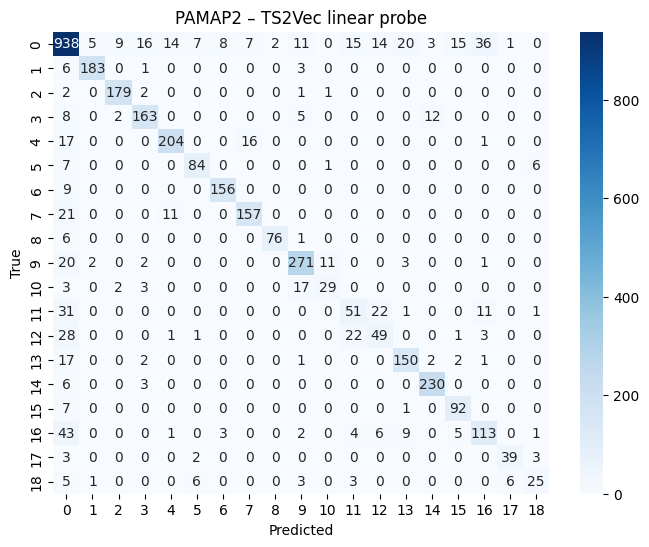

In [106]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
from sklearn.linear_model    import LogisticRegression
from sklearn.pipeline        import make_pipeline
from sklearn.metrics         import accuracy_score, f1_score
import seaborn as sns, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

X_tr, X_te, y_tr, y_te = train_test_split(
    simclr_embeds, labels, test_size=0.2, stratify=labels, random_state=42)

probe = make_pipeline(
    StandardScaler(),
    LogisticRegression(max_iter=500, multi_class='multinomial', solver='lbfgs')
).fit(X_tr, y_tr)

acc  = accuracy_score(y_te, probe.predict(X_te))
f1   = f1_score(y_te, probe.predict(X_te), average='macro')
print(f"SimCLR-TSC  | Accuracy={acc:.3f} | Macro-F1={f1:.3f}")
print(classification_report(y_te, probe.predict(X_te), digits=3))

cm = confusion_matrix(y_te, probe.predict(X_te))
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('PAMAP2 – TS2Vec linear probe')
plt.show()


draft code

In [71]:

import torch, random, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
e


DEVICE   = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
BATCH    = 256
SEEDS    = [0, 1, 2]      # three runs → mean ± sd
WINDOWS  = all_windows    # your cached (N,L,C) float32 ndarray
LABELS   = labels         # activity labels (N,)

# ------------------------------------------------------------
# 1.  Helper: probe + score
# ------------------------------------------------------------
def probe_and_score(emb):
    Xtr, Xte, ytr, yte = train_test_split(
        emb, LABELS, test_size=0.2, stratify=LABELS, random_state=42)
    pipe =  make_pipeline(
        StandardScaler(),
        LogisticRegression(max_iter=500, solver='lbfgs', multi_class='multinomial')
    ).fit(Xtr, ytr)
    yhat = pipe.predict(Xte)
    acc  = accuracy_score(yte, yhat)
    f1   = f1_score(yte, yhat, average='macro')
    return acc, f1

# ------------------------------------------------------------
# 2.  Wrapper for each SSL method
# ------------------------------------------------------------
def run_simclr(seed):
    from tsm.simclr import SimCLR      # repo: TimeseriesContrastiveModels :contentReference[oaicite:0]{index=0}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = SimCLR(in_channels=WINDOWS.shape[2], hidden_dim=256, \
                   projection_dim=128, jitter_scale=0.01, crop_ratio=0.5).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)  # (N,D) NumPy
    return probe_and_score(emb)

def run_tstcc(seed):
    from tstcc.models import TSTCC    # repo: emadeldeen24/TS-TCC :contentReference[oaicite:1]{index=1}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = TSTCC(in_channels=WINDOWS.shape[2], hidden_dim=256).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)
    return probe_and_score(emb)

def run_cpc(seed):
    from ults.models import CPC       # repo: ULTS library :contentReference[oaicite:2]{index=2}
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)

    model = CPC(in_channels=WINDOWS.shape[2], hidden_dim=256).to(DEVICE)
    model.fit(WINDOWS, batch_size=BATCH, epochs=20, device=DEVICE)
    emb   = model.encode(WINDOWS, device=DEVICE)
    return probe_and_score(emb)

# ------------------------------------------------------------
# 3.  Run 3 seeds per method
# ------------------------------------------------------------
records = []
for name, runner in [('SimCLR-TSC', run_simclr),
                     ('TS-TCC',     run_tstcc),
                     ('CPC',        run_cpc)]:
    accs, f1s = [], []
    for s in SEEDS:
        acc, f1 = runner(s)
        accs.append(acc); f1s.append(f1)
    records.append({
        'Method': name,
        'Acc mean':  np.mean(accs), 'Acc std':  np.std(accs),
        'F1 mean':   np.mean(f1s),  'F1 std':   np.std(f1s)
    })

# ------------------------------------------------------------
# 4.  Show tidy results table
# ------------------------------------------------------------
pd.DataFrame(records).set_index('Method').round(3)


ERROR: git+https://github.com/findalexli/TimeseriesContrastiveModels.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: git+https://github.com/emadeldeen24/TS-TCC.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.
ERROR: git+https://github.com/mqwfrog/ULTS.git does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


ModuleNotFoundError: No module named 'tsm'